# Calibration-Less Multi-coil (CaLM) MRI
Angshul Majumdar and Rabab K.Ward, 2012

## Assumption
- Sensitivity encoded images of the different coils are consistent with each other
- Image is sparse in some basis
- Measurement matrix has RIP


## Image reconstruction
The data aquistion can be expressed as s 

$$y_i = PFS_ix + \eta_i,  \quad i = 1,\dots,C \qquad (1)$$

where 
- $x \in \mathbb{R}^n$ is the vectorized image
- $S_i$ is the diagonalized smooth sensitivity map of the $i$-th coil-
- $P$ is a fat $m \times n, \: m < n $ permuation matrix for undersamlpling the k-space (each row in P has only one $1$ and rest are zeros)
- $y_i \in \mathbb{C}^m $ is the undersampled k-space data of $i$-th coil
- $\eta$ denotes the noise.

Denoting the sensitivity encoded images by $x_i = S_i x$, we further reformulate above equation as 

$$y_i = PFx_i + \eta_i,  \quad i = 1,\dots,C \qquad (2)$$

Now, employing the wavelet transform on the sensitivity encoded images using the transformation matrix $W$, we obtain

$$y_i = PFW^T\alpha_i + \eta_i,  \quad i = 1,\dots,C \qquad (3)$$

with wavelet coefficents $\alpha_i$.
Alternatively, by concatinating all $y_i$ into one large measurement vector $y = \begin{bmatrix}y_1\\ \vdots \\ y_C\end{bmatrix}$ yields

$$ y = A\alpha +  \eta, \qquad (4)$$

where $A = \text{diag}\bigg(\begin{bmatrix} PFW^T \\ \vdots \\ PFW^T \end{bmatrix}\bigg)$ is the measurement matrix, $\alpha = \begin{bmatrix}\alpha_1\\ \vdots \\ \alpha_C\end{bmatrix}$, and $\eta = \begin{bmatrix}\eta_1\\ \vdots \\ \eta_C\end{bmatrix}$.

The task is now to solve (4) for the coefficiens $\alpha$. Since (4) is an undertermined equations system, we employ the theories of compressive sensing to reconstructed a unique solution. That is, we assume 

1) the coefficient vector $\alpha$ is sparse,

2) the measurement matrix $A$ satisfies the restricted isometric property (RIP).

Typically for MRI images, their wavelet coeffiecents are sparse, thus assuming that $\alpha$ is sparse is a reasonable assumption. Furhermore, we do not only assume $\alpha$ is sparse but rather that it is _group-sparse_. That means the different $\alpha_i$ share the approximatelty the same support, but not necessarily the same values at the non-zero entries. This follows from the assumption that the sensitivity maps $S_i$ are smooth and therefore the multiplication $x_i = S_i x$ will yield discontinuities at the same positions as the image $x$. And as the wavelet transform encodes the discontinuities we can expect $\alpha$ to be group-sparse.

Remark: The authors for the CaLM MRI paper claim that also the values of the coefficents at the same indices in different $\alpha_i$s will be similar; however, I cannot comprehend their reasoning as I think that I could find a smooth sensitivity map to show that it is not true.

Denoting the matrix $\alpha_S = \begin{bmatrix}\alpha_1 & \cdots & \alpha_C\end{bmatrix}$ the optimization to obtain $\alpha$ becomes

$$ \hat{\alpha}_S = \text{argmin}_{\alpha_S}\: ||\alpha_S||_{2,1}, \quad \text{s.t.} \: ||y-A\alpha||_2 \leq \epsilon \qquad(5)$$

where $\epsilon = \sqrt{CN\sigma}$ and $||\cdot||_{2,1}$ denotes the $\ell_{2,1}$ norm.

Formulation (5) is a synthesis prior formulation; however, a solution can also be obtained by solving the analysis prior formulation

$$ \hat{X} = \text{argmin}_{X} \: ||WX||_{2,1}, \quad \text{s.t.} \: ||y-\text{vec}(PFX)||_2 \leq \epsilon, \qquad(6)$$

where $X = \begin{bmatrix}x_1 & \cdots & x_C\end{bmatrix}$. The analysis prior formulation thus solves for the sensitivity encoded images directly. Since $W$ is a orthogonal matrix, (5) and (6) yield the same solution in theory. 

Upon obtaining the sensitivity encoded images, the final image $\hat{x}$ is computed as the sum of squares, i.e, $\hat{x} = \sqrt{\sum_{i = 1}^C \hat{x}_i^2}$.


## Sampling Approaches

Periodic:
- traditionally the most often used parallel MRI acceleration method
- unsuitable for CS reconstruction

Gaussian:
- yields good results
- can not be efficiently acquired

Radial:
- practical and efficient for CS based MR
- robust to object motion and ghosting artifcts
- reconstructing images more difficult 

<img src="./pics/calm_sampl.png">

## Similarity and differences to GRAPPA and SENSE  

Similiarities:

- Mulit-coil
- Produces one sensitivity encoded image for each coil, like GRAPPA
- Formalism like SENSE

Differences:

- No calibration needed, no parameter estimation (sensitivity maps in SENSE or interpolation weights in GRAPPA)
- Insensitive to calibration errors
- Unlike SENSE, one image each coil
- Underdetermined equation system

Negatves:

- Can lead to oversmooth, blurred images
- Depended on the sampling approach and sparsefying transform

### My Criticism

- Consitency assumptions of sensitivity encoded images of the different coils
- SOS of sensitivity encoded images
- Is group sparsity really needed
- No really effective usage of multi coil setting




<img src="pics/img_for_pres.png">

From paper: Reconstructed images from Gaussian Sampling. Left to right: brain, Shepp-Logan Phantom and UBC MRI Slice 1; top to bottom: GRAPPA, CS SENSE, CaLM MRI synthesis, CaLM MRI analysis.

## Low-Rank Formulation for CaLM MRI
An alternative formulation of CaLM MRI is its low rank formulation. That is, we assume $X$ to be low rank and solve

$$ \hat{X} = \text{argmin}_X \: ||Y −PFX||_F$$

where $Y = \begin{bmatrix}y_1 & \cdots & y_C\end{bmatrix}$, and X is constrained be low rank. The low rank assumption comes from the observation that neighbouring coils yield approximately linearly correlated images.

## CaLM Reconstruction Example
#### Julia implementation by adjusting the algorithm from
_Il Yong Chun, Ben Adcock, and Thomas M. Talavage, Efficient Compressed Sensing SENSE pMRI Reconstruction With Joint Sparsity Promotion, 2015_

In [1]:
using LinearAlgebra, MAT, FFTW, Wavelets, Random, PyPlot, Distributions, Images

### Utility functions 

In [2]:
function scale(x)
    x = (x.-minimum(x))
    x = x./maximum(x)
    return x
end

function sampling(ub)
    # Here we sample points in a Gaussian distributed fashion
    # The truncation lower bound
    lb = 1  
    
    # The truncation upper bound
    ub = ub   
    
    # The mean of the truncated Normal
    mu = trunc(Int32, (ub+lb)/2)  
    
    # The standard deviation of the truncated Normal
    sigma = mu/3
    
    #Construct the distribution type
    d = Truncated(Normal(mu, sigma), lb, ub)  
    
    return trunc.(Int64, rand(d, samp));
end

## Operators, Notation as in Paper from Efficient Compressed Sensing SENSE pMRI Reconstruction With Joint Sparsity Promotion
# Il Yong Chun, Ben Adcock, and Thomas M. Talavage, 2015
function SoS(x)
    x = sum(abs.(x).^2, dims = 3)
    return sqrt.(x)
end

function Jsoftshrink(x, lambda)
    n = sqrt.(sum(abs.(x).^2, dims = 3));
    x = x ./ n;
    n = n .- lambda;
    n = max.(n, 0);
    return x .* n;
end

function Psi(x)
    return dwt(x, wavelet(WT.db2));
end

function Psi_H(x)
    return idwt(x, wavelet(WT.db2));
end

function Phi(x)
    return fftshift(fft(x));
end

function Phi_H(x)
    return ifft(ifftshift(x));
end

function Phi_c(x)
    y = similar(y_data);
    for i = 1:C
        y[:,:,i] = Phi(x[:,:,i]);
    end
    return y
end

function Phi_cH(x)
    y = similar(y_data);
    for i = 1:C
        y[:,:,i] = Phi_H(x[:,:,i]);
    end
    return y
end

function Psi_c(x)
    y = similar(y_data);
    for i = 1:C
        y[:,:,i] = Psi(x[:,:,i]);
    end
    return y
end

function Psi_cH(x)
    y = similar(y_data);
    for i = 1:C
        y[:,:,i] = Psi_H(x[:,:,i]);
    end
    return y
end

function F_Omega_c(x)
    y = similar(y_data);
    for i = 1:C
        y[:,:,i] = Phi(x[:,:,i]);
    end
    y = P_Omega.*y;
    return y
end

function F_Omega_cH(x)
    y = P_Omega.*x;
    for i = 1:C
        y[:,:,i] = Phi_H(y[:,:,i]);
    end
    return y
end;

# Define Operator inv(Lambda)
function apply_invLambda(x)
     return inv_Lambda.*x;
end;

### Initialisation

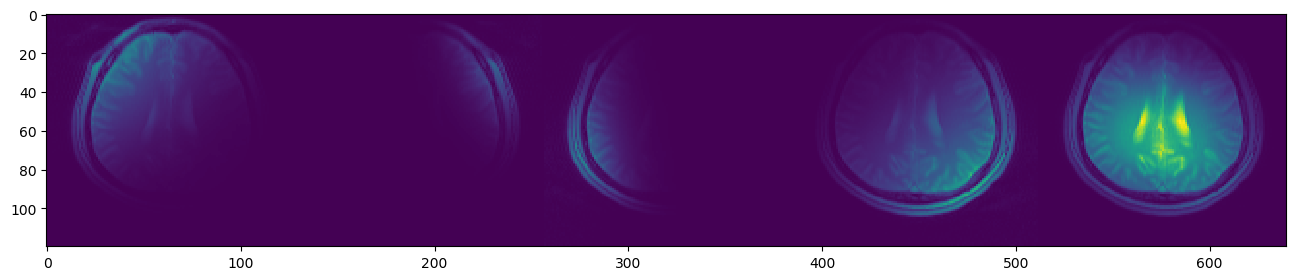

In [3]:
C = 5;                                # There are C = 5 coils
height, width = 120, 128              # Standard is 120, 128

# Load sensitivity maps
file = matopen("data/coil_sensitivity_map.mat");
coilSensitivityMaps = read(file, "coil_map");
close(file);

# Resize sensitivity maps
sm = zeros(height, width, C)
for i = 1:5
    sm[:,:,i] =  imresize(coilSensitivityMaps[:,:,i], (height, width));
end
coilSensitivityMaps = sm;

# Load coil images
file = matopen("data/brain_coil.mat");
coilScans = read(file, "brain_coil_tmp");
close(file);
cs = zeros(height, width, C)
for i = 1:C
    cs[:,:,i] =  imresize(coilScans[:,:,i], (height, width));
end
coilScans = cs;

## Load Shepp-Loagn phantom
# np = max(height, width)
# phantom = shepp_logan(np, highContrast=true);
# phantom = imresize(phantom, (height, width))
# # Apply sensitivity maps
# coilScans = coilSensitivityMaps.*phantom;

## Load image from folder
# img = load("413469fd-9354-400c-88e3-b29e7c711a05.jpg")
# img = Gray.(img)
# img = convert(Array{Float64}, img);
# img = imresize(img, (height, width))
## Apply sensitivity maps
# coilScans = coilSensitivityMaps.*img;

# Display sensitivity encoded images
imagedisp = reshape(coilScans, (height, width*C))
fig = figure(figsize=(16,16))
imshow(abs.(imagedisp[:,:]));

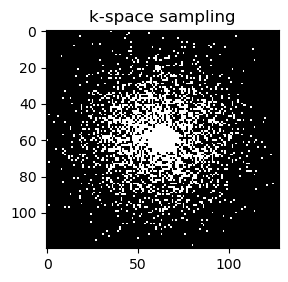

Sampled: 2381
Sampled/Full: 15.501%


In [22]:
## Simulate k-space sampling
# Number of samples
samp = 3000

# Indices of samples (possibly duplicated coordinates here)
ind = hcat(sampling(height),sampling(width));

# Intialise sampling matrix
P_Omega = zeros(height,width);

# Create mask for sampling middle of k-space
x = range(-height/2, height/2, length = height);
y = range(-width/2, width/2, length = width)';
mask = sqrt.(x.^2 .+ y.^2).< sqrt((height+width)/4);
P_Omega[mask] .= 1

# Finish sampling matrix
for i = 1: samp
    P_Omega[ind[i,1],ind[i,2]] = Int(1)
end

## Different sampling for each coil
# for j = 2:C
#     P =zeros(height,width);
#     P[mask] .= 1
#     # Indices of samples (possibly duplicated coordinates here)
#     ind = hcat(sampling(height),sampling(width));
#     for i = 1: samp
#         P[ind[i,1],ind[i,2]] = Int(1)
#     end
#     P_Omega = [P_Omega P]
# end
# P_Omega = reshape(P_Omega, height, width, C)

figure(figsize=(3,3))
imshow(P_Omega, cmap = "gray")
title("k-space sampling");

println("Sampled: ", sum(P_Omega .> 0));
println("Sampled/Full: ", round(sum(P_Omega .> 0)/(height*width)*100, digits = 3), "%");

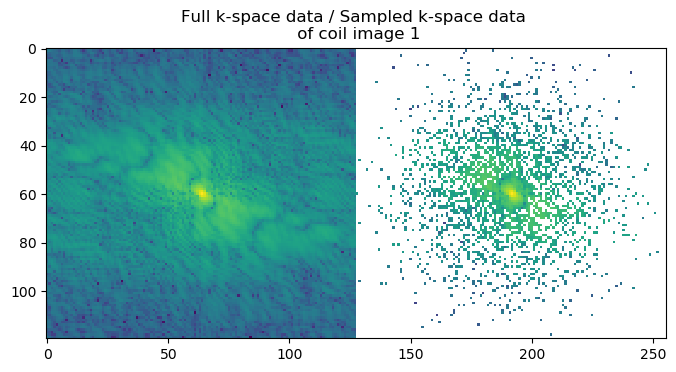

In [23]:
## Simulate K-Space data
# Full K-Space data of coil images
y_data = similar(coilScans.+0*im);
y_original = Phi_c(coilScans.+0*im); 

# Add some noise
n = 0*randn(height,width,C)

# Sample k-space data
y_data = P_Omega.*(y_original + n);

imagedisp = hcat(log.(abs.(y_original[:,:,1])),log.(abs.(y_data[:,:,1])));
fig = figure(figsize=(8,8));
imshow(abs.(imagedisp[:,:]));
title("Full k-space data / Sampled k-space data \n of coil image 1");

### Reconstruction

In [24]:
# Define hyperparameters 
α = 0.05;
β = 2*α;
ν = 2*α;

# Precompute inv(Lambda)
inv_Lambda = 1 ./(α*P_Omega.^2 .+(β + ν));

In [25]:
## Initialise values  
y = y_data;
x = Phi_cH(y);
ds = zeros(height, width, C);
dpsi = ds;
bs = ds;
bpsi = ds;
# x = ds;

In [39]:
# Number of inner Bregman iterations 
nInner = 1; 

# Number of outer Bregman iterations 
nOuter = 1000; 

# Alternatively can define threshold for stopping condition instead of nOuter
δ = 1e0;

#### Execute

In [40]:
err = y_data - F_Omega_c(x);
for nOut = 1:nOuter
    y = y + err;
    for nIn = 1:nInner
        ds = Phi_cH(apply_invLambda(Phi_c(α*F_Omega_cH(y) + β*Psi_cH(dpsi-bpsi) + ν*(x+bs))));
        dpsi = Jsoftshrink(Psi_c(ds) + bpsi, 1/β);
        bs = bs + x - ds;
        bpsi = bpsi + Psi_c(ds) - dpsi;
        x = ds - bs;
    end
    err = y_data - F_Omega_c(x);
    if norm(err) < δ
        println("Tolerance reached.")
        break;
    end
end
if norm(F_Omega_c(x)-y_data) > δ
    println("Max number of Iterations reached.")
end
print("||F_Omega_c(x)-y_data|| = ", norm(F_Omega_c(x)-y_data))

Tolerance reached.
||F_Omega_c(x)-y_data|| = 0.9987294559055108

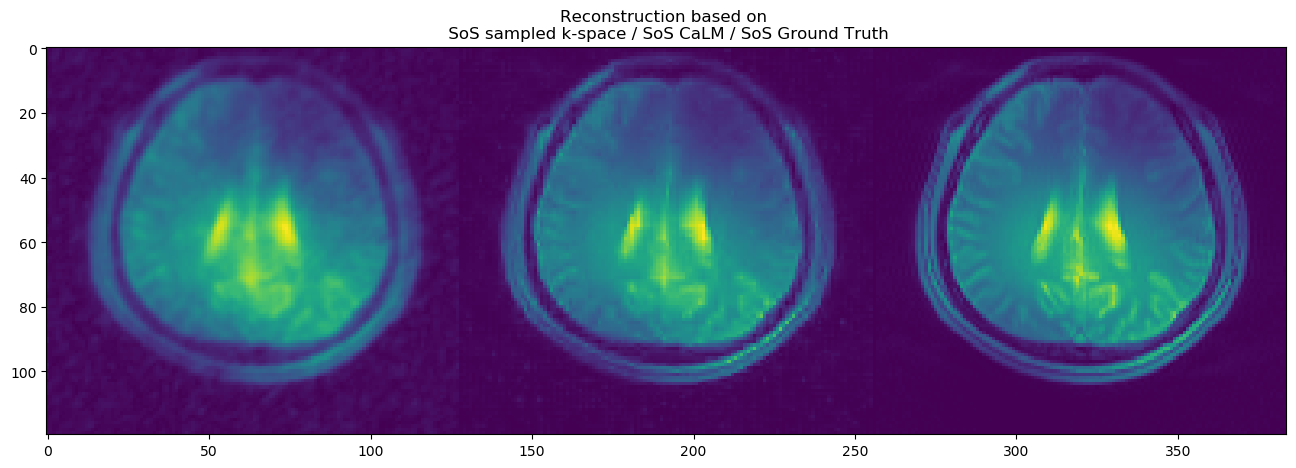

In [41]:
# Display results
imagedisp = hcat(scale(SoS(Phi_cH(y_data))[:,:,1]), scale(SoS(x)[:,:,1]), scale(SoS(Phi_cH(y_original))[:,:,1]));
fig = figure(figsize=(16,16));
imshow(abs.(imagedisp[:,:]));
title("Reconstruction based on \n SoS sampled k-space / SoS CaLM / SoS Ground Truth");